# Titanic: Machine Learning from Disaster - Exploratory Data Analysis

The input files are available from the [download](https://www.kaggle.com/c/titanic/data) section of the contest:

**Data Dictionary**
- survival (Survival): 0 = No, 1 = Yes
- pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd
- sex (Sex)	
- Age (Age in years)	
- sibsp (# of siblings / spouses aboard the Titanic)
- parch (# of parents / children aboard the Titanic)
- ticket (Ticket number)
- fare (Passenger fare)
- cabin (Cabin number)
- embarked (Port of Embarkation): C = Cherbourg, Q = Queenstown, S = Southampton

**Variable Notes**
- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [ ]:
import gc
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

random.seed(1)
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15, 6)})

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train = pd.read_csv('input/train.csv', index_col='PassengerId', usecols=['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'])
df_train = reduce_memory_usage(df_train)
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  0.07 MB
Reduced memory usage:  0.03 MB (50.0% reduction)
891 records and 9 features in train set.


In [4]:
df_test = pd.read_csv('input/test.csv', index_col='PassengerId', usecols=['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'])
df_test = reduce_memory_usage(df_test)
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  0.03 MB
Reduced memory usage:  0.02 MB (45.8% reduction)
418 records and 8 features in test set.


## Exploratory Data Analysis

In [5]:
df_train[:3]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.250000,NaN,S
2,1,1,female,38.0,1,0,71.312500,C85,C
3,1,3,female,26.0,0,0,7.925781,NaN,S


In [6]:
df_train['Sex'] = df_train['Sex'].map({'male': 1, 'female': 0})
df_test['Sex'] = df_test['Sex'].map({'male': 1, 'female': 0})

In [7]:
df_train.count()

Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Cabin       204
Embarked    889
dtype: int64

In [8]:
df_test.count()

Pclass      418
Sex         418
Age         332
SibSp       418
Parch       418
Fare        417
Cabin        91
Embarked    418
dtype: int64

### Age

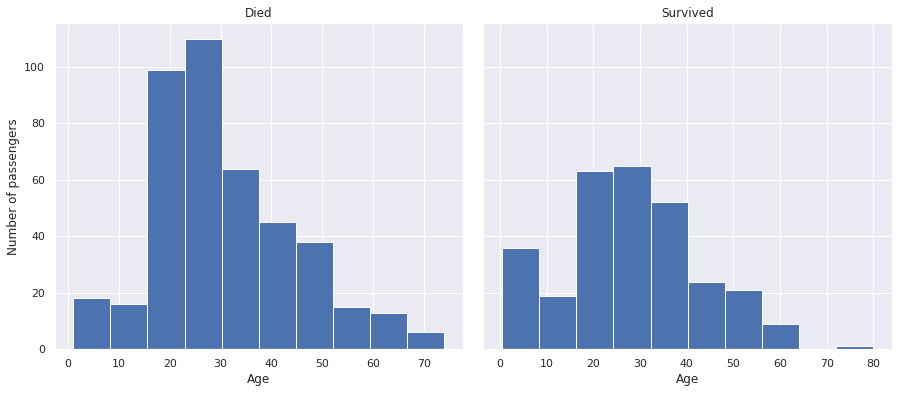

In [9]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title("Died")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Age'].hist(bins=10, ax=ax[0])

ax[1].set_title("Survived")
ax[1].set_xlabel('Age')
df_train[df_train['Survived'] == 1]['Age'].hist(bins=10, ax=ax[1])

In [10]:
mean_d = df_train[df_train['Survived'] == 0]['Age'].mean()
mean_s = df_train[df_train['Survived'] == 1]['Age'].mean()
print('Average age of the died passangers: {:.2f}'.format(mean_d))
print('Average age of the survived passangers: {:.2f}'.format(mean_s))

Average age of the died passangers: 30.62
Average age of the survived passangers: 28.33


In [11]:
df_train[df_train['Survived'] == 0]['Age'] = mean_d
df_train[df_train['Survived'] == 1]['Age'] = mean_s

In [12]:
df_train[df_train['Age'].isna()][:3]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
6,0,3,1,NaN,0,0,8.460938,NaN,Q
18,1,2,1,NaN,0,0,13.000000,NaN,S
20,1,3,0,NaN,0,0,7.226562,NaN,C


### Cabin

### Embarked

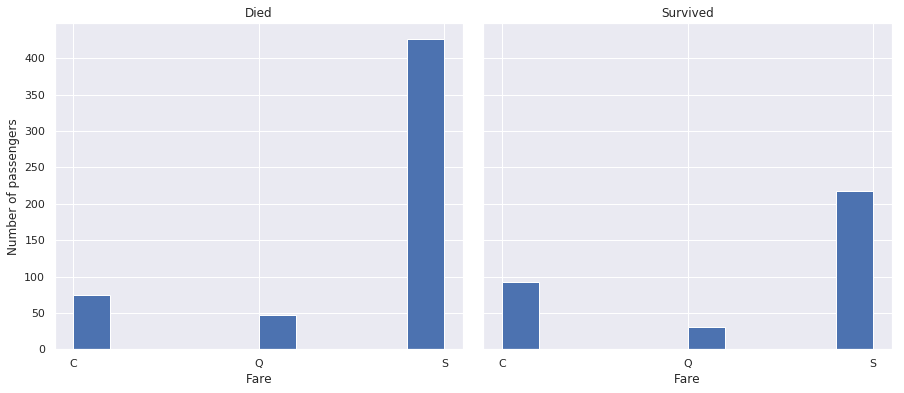

In [13]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Fare')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Embarked'].hist(bins=10, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Fare')
df_train[df_train['Survived'] == 1]['Embarked'].hist(bins=10, ax=ax[1])

### Fare

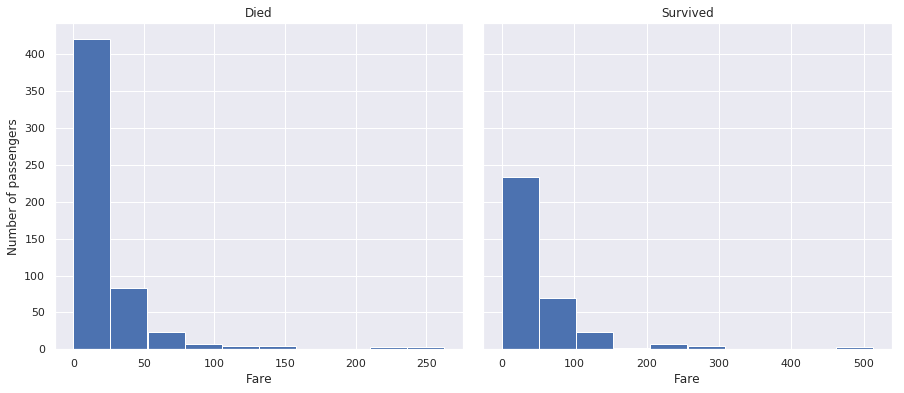

In [14]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Fare')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Fare'].hist(ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Fare')
df_train[df_train['Survived'] == 1]['Fare'].hist(ax=ax[1])

### PClass

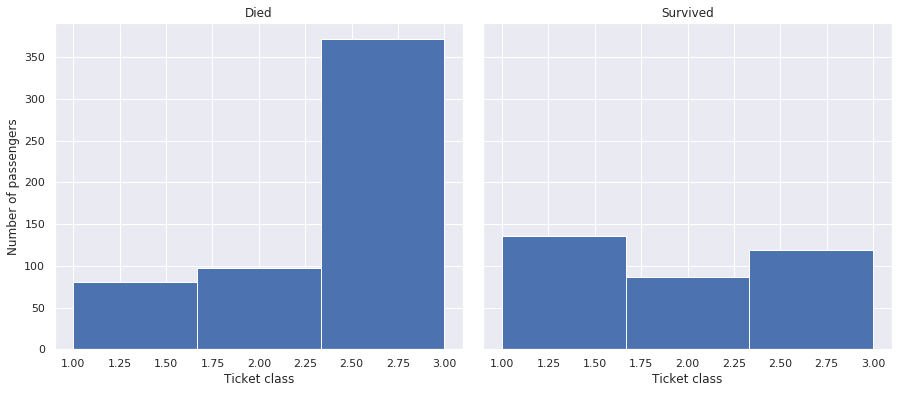

In [15]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Ticket class')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Pclass'].hist(bins=3, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Ticket class')
df_train[df_train['Survived'] == 1]['Pclass'].hist(bins=3, ax=ax[1])

### Sex

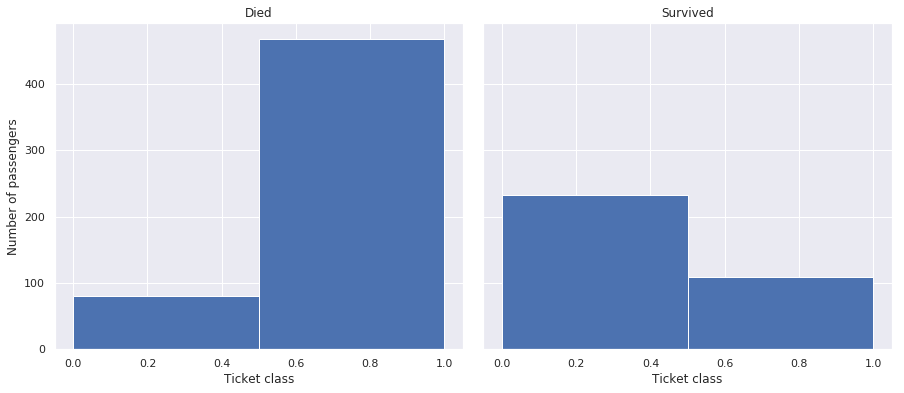

In [16]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Ticket class')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Sex'].hist(bins=2, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Ticket class')
df_train[df_train['Survived'] == 1]['Sex'].hist(bins=2, ax=ax[1])

### Siblings/Spouse

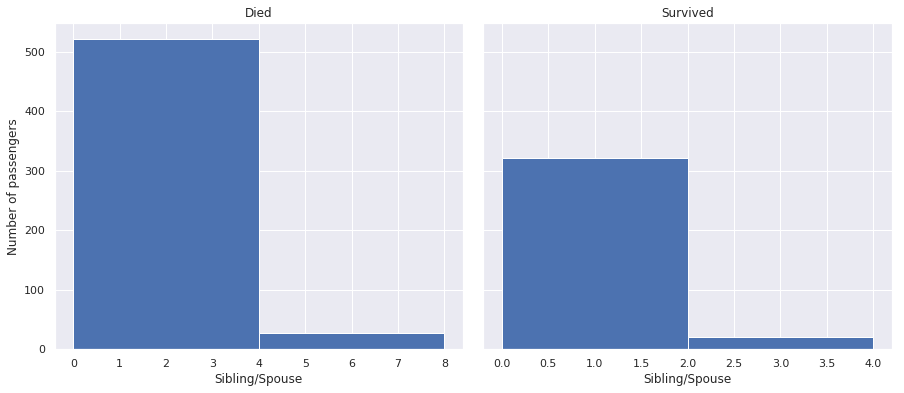

In [17]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Sibling/Spouse')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['SibSp'].hist(bins=2, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Sibling/Spouse')
df_train[df_train['Survived'] == 1]['SibSp'].hist(bins=2, ax=ax[1])

### Parents/Children

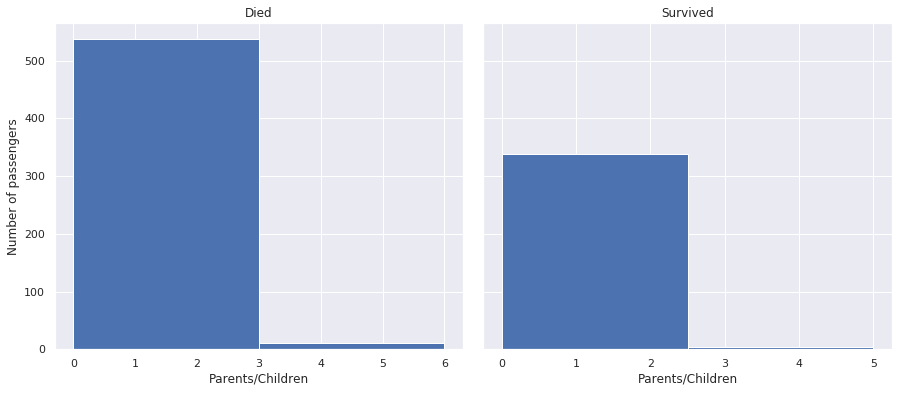

In [18]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Parents/Children')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Parch'].hist(bins=2, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Parents/Children')
df_train[df_train['Survived'] == 1]['Parch'].hist(bins=2, ax=ax[1])

## Dimension reduction

In [19]:
df_train.count()

Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Cabin       204
Embarked    889
dtype: int64

In [20]:
df_train.fillna(0, inplace=True)

### PCA

In [21]:
features = df_train.select_dtypes(include=['int8', 'int64', 'float16']).columns

In [22]:
features

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [23]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_train[features].values)

df_train['pca_1'] = pca_result[:,0]
df_train['pca_2'] = pca_result[:,1]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.89008078 0.10897847]


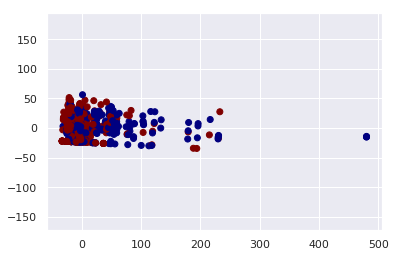

In [24]:
plt.scatter(df_train['pca_1'], df_train['pca_2'], c=df_train['Survived'], cmap="jet_r")
plt.axis('equal');

### t-SNE

In [25]:
n_sne = 3000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_train.loc[:, features].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.003s...
[t-SNE] Computed neighbors for 891 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 0.960734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.545078
[t-SNE] KL divergence after 300 iterations: 0.334052


In [26]:
df_tsne = df_train.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

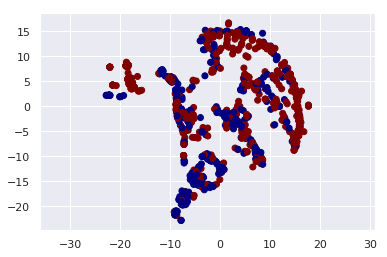

In [27]:
plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=df_tsne['Survived'], cmap="jet_r")
plt.axis('equal');

## Training

### LightGBM

In [28]:
df_train[:3]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,pca_1,pca_2
PassengerId,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.250000,0,S,-25.022395,-0.445484
2,1,1,0,38.0,1,0,71.312500,C85,C,39.837318,12.050181
3,1,3,0,26.0,0,0,7.925781,0,S,-24.128417,3.521977


In [29]:
df_train_columns = [c for c in df_train.columns if c not in ['PassangerId']]
target = df_train['Survived']
del df_train['Survived']

In [31]:
df_train.shape, target.shape

((891, 10), (891,))

In [32]:
%%time
param = {
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "boosting": "gbdt",

    "feature_fraction": 0.9,
    "feature_fraction_seed": 1,

    "lambda_l1": 0.1,
    #"lambda_l2": 0.001,
    "learning_rate": 0.01,

    #"max_bin": 5,
    'max_depth': -1,
    "metric": "rmse",
    "min_data_in_leaf": 30,
    #"min_gain_to_split": 0.1,
    #"min_sum_hessian_in_leaf": 1e-3,
    "min_child_samples": 20,
    #"num_iterations": 100,
    #"num_boost_round": 100,
    "num_leaves": 31,
    "nthread": -1,

    "objective": "regression",

    "random_state": 402,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['Pclass'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

NameError: name 'StratifiedKFold' is not defined